## Import necessary modules

In [1]:
import findspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

## Initialize Spark

In [2]:
findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayAnalysis") \
    .config("spark.driver.memory", "30g") \
    .getOrCreate()

spark

24/12/13 09:32:04 WARN Utils: Your hostname, yurii-pc resolves to a loopback address: 127.0.1.1; using 192.168.0.111 instead (on interface enp4s0)
24/12/13 09:32:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/13 09:32:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load the datasets

In [3]:
file_path_1 = "resources/flights_sample_3m.csv"
df = spark.read.csv(file_path_1, header=True, inferSchema=True)

years = range(2009, 2019)
df2 = None
for year in years:
    file_path = f"resources/{year}.csv"
    if df2 is None:
        df2 = spark.read.csv(file_path, header=True, inferSchema=True)
    else:
        new_df = spark.read.csv(file_path, header=True, inferSchema=True)
        df2 = df2.union(new_df)
        del new_df

## Merge two datasets

First, we have to make sure, datasets' schemas align and all missing columns compared to each others are resolved

In [4]:
df2 = df2.drop("Unnamed: 27")
df = df.drop("AIRLINE_DOT", "DOT_CODE")

df2 = df2.withColumnRenamed("OP_CARRIER", "AIRLINE_CODE").withColumnRenamed("OP_CARRIER_FL_NUM", "FL_NUMBER").withColumnRenamed("ACTUAL_ELAPSED_TIME", "ELAPSED_TIME").withColumnRenamed("CARRIER_DELAY", "DELAY_DUE_CARRIER").withColumnRenamed("WEATHER_DELAY", "DELAY_DUE_WEATHER").withColumnRenamed("NAS_DELAY", "DELAY_DUE_NAS").withColumnRenamed("SECURITY_DELAY", "DELAY_DUE_SECURITY").withColumnRenamed("LATE_AIRCRAFT_DELAY", "DELAY_DUE_LATE_AIRCRAFT")

And next we add all missing info to second data set. This is done by looging up values that are present in the first dataset, or adding those that are missing manually.

In [5]:
origin_city_dict = dict(df.select("ORIGIN", "ORIGIN_CITY").rdd.map(lambda row: (row["ORIGIN"], row["ORIGIN_CITY"])).collect())
origin_city_dict.update({
    'MOD': 'Modesto, CA',
    'CEC': 'Crescent City, CA',
    'IPL': 'Imperial, CA',
    'IYK': 'Inyokern, CA',
    'CIC': 'Chico, CA',
    'OXR': 'Oxnard, CA',
    'LMT': 'Klamath Falls, OR',
    'TEX': 'Texas City, TX',
    'PFN': 'Panama City, FL',
    'CLD': 'Carlsbad, CA',
    'MWH': 'Moses Lake, WA',
    'UTM': 'Uttica, NY',
    'TUP': 'Tupelo, MS',
    'MCN': 'Macon, GA',
    'FOE': 'Topeka, KS',
    'UST': 'UST, TX',
    'EFD': 'Ellington Field, TX',
    'ENV': 'Enid, OK',
    'TKI': 'Terrell, TX',
    'IFP': 'Laughlin/Bullhead City, AZ',
    'YNG': 'Youngstown, OH',
    'FNL': 'Fort Collins, CO'
})
destination_city_dict = dict(df.select("DEST", "DEST_CITY").rdd.map(lambda row: (row["DEST"], row["DEST_CITY"])).collect())

airline_dict = dict(df.select("AIRLINE_CODE", "AIRLINE").rdd.map(lambda row: (row["AIRLINE_CODE"], row["AIRLINE"])).collect())
airline_dict.update(
    {
    'NW': 'Northwest Airlines',
    'US': 'US Airways',
    'XE': 'Sun Country Airlines',
    'FL': 'AirTran Airways',
    'CO': 'Continental Airlines',
    'VX': 'Virgin America'
}
)

def get_origin_city(origin):
    origin = origin_city_dict.get(origin, None)
    dest = destination_city_dict.get(origin, None)
    return origin if origin is not None else dest

def get_destination_city(destination):
    dest = destination_city_dict.get(destination, None)
    origin = origin_city_dict.get(destination, None)
    return dest if dest is not None else origin

def get_airline(airline_code):
    return airline_dict.get(airline_code, None)

get_origin_city_udf = udf(get_origin_city, StringType())
get_destination_city_udf = udf(get_destination_city, StringType())
get_airline_udf = udf(get_airline, StringType())

df2 = df2.withColumn("ORIGIN_CITY", get_origin_city_udf(col("ORIGIN")))
df2 = df2.withColumn("DEST_CITY", get_origin_city_udf(col("DEST")))
df2 = df2.withColumn("AIRLINE", get_airline_udf(col("AIRLINE_CODE")))

Ensure same columns order before merge

In [6]:
df2 = df2.select(
    "FL_DATE",
    "AIRLINE",
    "AIRLINE_CODE",
    "FL_NUMBER",
    "ORIGIN",
    "ORIGIN_CITY",
    "DEST",
    "DEST_CITY",
    "CRS_DEP_TIME",
    "DEP_TIME",
    "DEP_DELAY",
    "TAXI_OUT",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN",
    "CRS_ARR_TIME",
    "ARR_TIME",
    "ARR_DELAY",
    "CANCELLED",
    "CANCELLATION_CODE",
    "DIVERTED",
    "CRS_ELAPSED_TIME",
    "ELAPSED_TIME",
    "AIR_TIME",
    "DISTANCE",
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
)

Now we are able to merge those two datasets together

In [7]:
df = df.union(df2)

df.printSchema()
df.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 

24/12/13 02:46:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+------------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|AIRLINE_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+------------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------

## Inspect the Data

In [8]:
null_counts = df.select([(sum(when(col(c).isNull(), 1).otherwise(0))).alias(c) for c in df.columns])
null_counts.show()

+-------+-------+------------+---------+------+-----------+----+---------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE|AIRLINE|AIRLINE_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY|DEST|DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+-------+-------+------------+---------+------+-----------+----+---------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------

Now visualize missing values

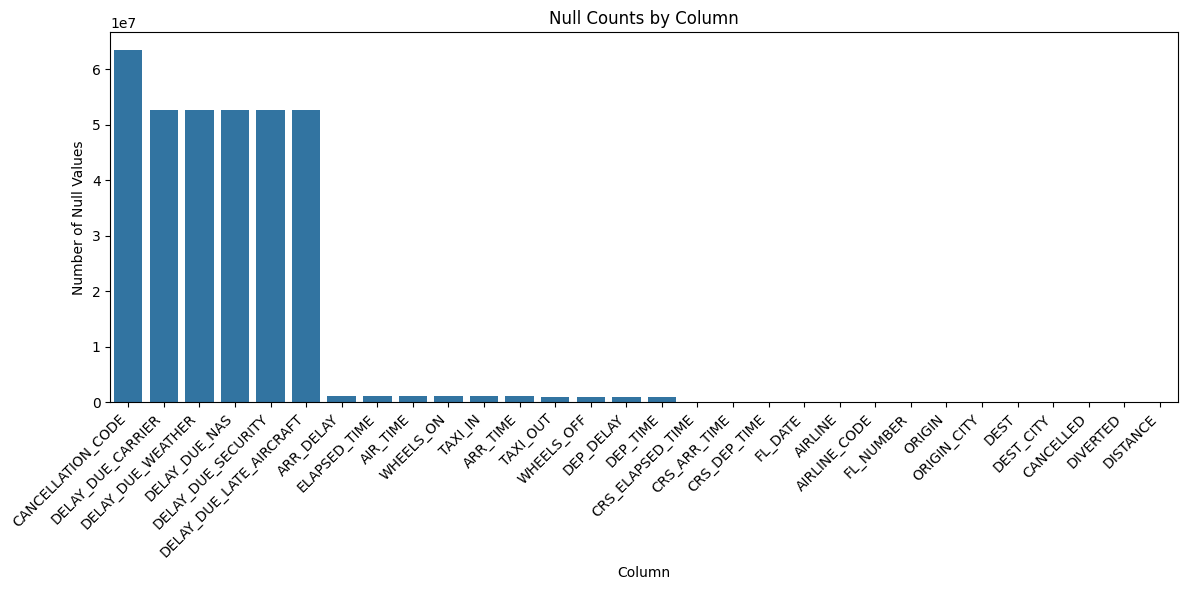

In [9]:
null_counts_list = null_counts.collect()[0].asDict()

sorted_null_counts = sorted(null_counts_list.items(), key=lambda x: x[1], reverse=True)
columns, null_values = zip(*sorted_null_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=columns, y=null_values)
plt.title("Null Counts by Column")
plt.xlabel("Column")
plt.ylabel("Number of Null Values")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

As we can see, some columns have a much larger number of missing values. After a closer inspection, one can see this is due to the fact that not cancelled flights don't have a cancellation code, and there only is one delay reason for each flight, which then results in empty values for all other reasons. Then there is another, so to say, category of columns by missing values count. those are flights that were cancelled and therefore there are no delays, times, etc. Then there are columns with no missing values at all. Those are properties that each flight has. For example airline, flight number, planned departure and arrival times.

## Display basic statistics on numeric columns

In [10]:
columns_to_keep = ["DEP_DELAY", "ARR_DELAY", "CRS_ELAPSED_TIME", "ELAPSED_TIME", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT", "AIR_TIME", "DISTANCE"]

filtered_df = df.select(*columns_to_keep)

filtered_df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------------+------------------+-----------------+
|summary|        DEP_DELAY|         ARR_DELAY|  CRS_ELAPSED_TIME|      ELAPSED_TIME| DELAY_DUE_CARRIER| DELAY_DUE_WEATHER|     DELAY_DUE_NAS| DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|          AIR_TIME|         DISTANCE|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------------+------------------+-----------------+
|  count|         63538645|          63349415|          64556890|          63352012|          11924603|          11924603|          11924603|           11924603|               11924603|          63352013|         64556964|
|   mean| 9.09448026472708| 4.680122207916206|137.20361702678056|133.04881688682596| 18.13119715599756|2.717

Here we can observe some basic statistics on numeric columns. For this we removed all categorical columns, for it  makes no sense to calculate mean of flight numbers, for example.

## Analyze airlines (carriers)

Lets take a look how many flights were made by each airline

In [11]:
df.groupBy("AIRLINE", "AIRLINE_CODE").count().orderBy("count").show()

+--------------------+------------+-------+
|             AIRLINE|AIRLINE_CODE|  count|
+--------------------+------------+-------+
|         Horizon Air|          QX|  20634|
|       Allegiant Air|          G4| 148959|
|  Northwest Airlines|          NW| 292400|
|      Virgin America|          VX| 389060|
|    Republic Airline|          YX| 459197|
|   PSA Airlines Inc.|          OH| 684110|
|    Spirit Air Lines|          NK| 684285|
|Continental Airlines|          CO| 740498|
|Hawaiian Airlines...|          HA| 777105|
|Frontier Airlines...|          F9| 967684|
|Sun Country Airlines|          XE|1105864|
|  Mesa Airlines Inc.|          YV|1128570|
|   Endeavor Air Inc.|          9E|1178714|
|     AirTran Airways|          FL|1218389|
|Alaska Airlines Inc.|          AS|1761006|
|     JetBlue Airways|          B6|2596813|
|          US Airways|          US|2657286|
|           Envoy Air|          MQ|3337516|
|ExpressJet Airlin...|          EV|4745527|
|United Air Lines ...|          

Now visualize this data

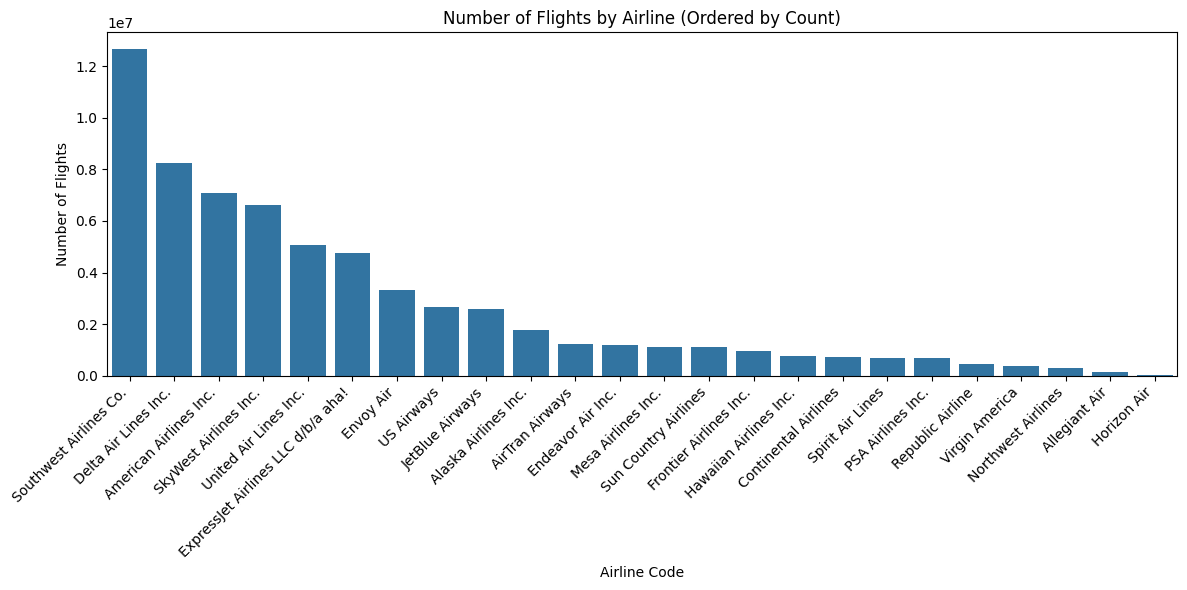

In [12]:
airline_counts = df.groupBy("AIRLINE").count().orderBy("count", ascending=False)

airline_counts_data = airline_counts.collect()
airline_codes = [row["AIRLINE"] for row in airline_counts_data]
counts = [row["count"] for row in airline_counts_data]

plt.figure(figsize=(12, 6))
sns.barplot(x=airline_codes, y=counts)
plt.title("Number of Flights by Airline (Ordered by Count)")
plt.xlabel("Airline Code")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Here we can see what airline conducted the most flights throughout all years that were in our dataset (2009 - 2023).

## Analyze cancelation

In [13]:
count = df.filter(col("CANCELLED") == 1).count()

print(f"Flights cancelled: {count}. Total flights: {df.count()}. Percentage: {count/df.count()*100:.2f}%.")

Flights cancelled: 1052349. Total flights: 64556964. Percentage: 1.63%.


Now as we can see, there are more than 60 million flights, and nearly 1 million of those were cancelled.

And what were the reasons for the cancellations

In [14]:
df = df.withColumn(
    "CANCELLATION_REASON",
    when(col("CANCELLATION_CODE") == "A", "Carrier")
    .when(col("CANCELLATION_CODE") == "B", "Weather")
    .when(col("CANCELLATION_CODE") == "C", "NAS")
    .when(col("CANCELLATION_CODE") == "D", "Security")
    .otherwise("Not Canceled")
)

df.groupBy("CANCELLATION_REASON").count().orderBy("count", ascending=False).show()

+-------------------+--------+
|CANCELLATION_REASON|   count|
+-------------------+--------+
|       Not Canceled|63504615|
|            Weather|  505218|
|            Carrier|  334926|
|                NAS|  187080|
|           Security|   25125|
+-------------------+--------+



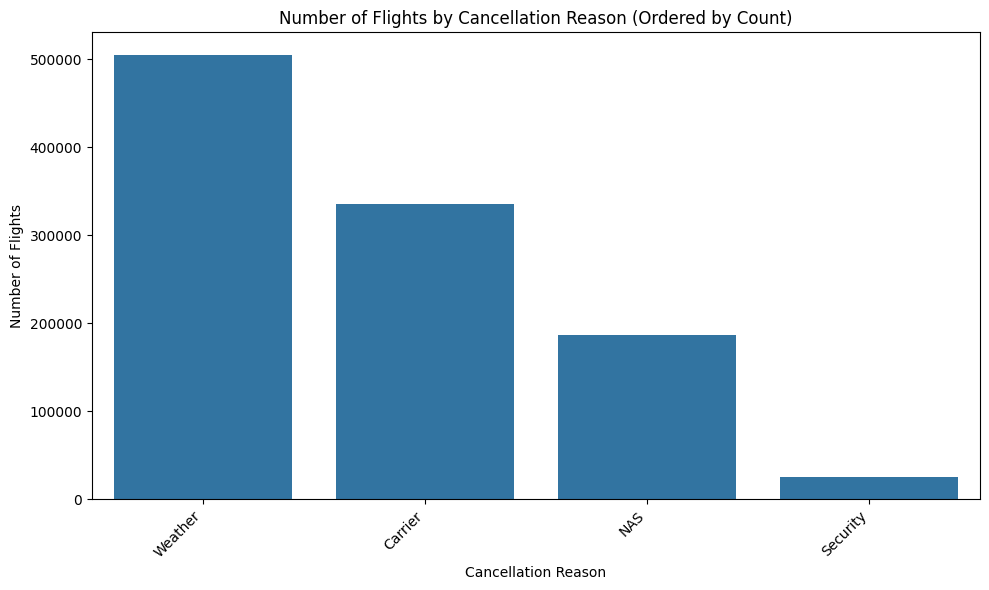

In [15]:
cancellation_reason_counts = df.filter(col("CANCELLATION_REASON") != "Not Canceled").groupBy("CANCELLATION_REASON").count().orderBy("count", ascending=False)

cancellation_reason_counts_data = cancellation_reason_counts.collect()
cancellation_reasons = [row["CANCELLATION_REASON"] for row in cancellation_reason_counts_data]
counts = [row["count"] for row in cancellation_reason_counts_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_reasons, y=counts)
plt.title("Number of Flights by Cancellation Reason (Ordered by Count)")
plt.xlabel("Cancellation Reason")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

As we can see, weather was the most common reason for cancellation with a substantial difference. Security was the least common one, which means security cheks are not that common of a reason for flights delay. 

## Analyze destinations

In [16]:
df.groupBy("DEST_CITY").count().orderBy("count", ascending=False).show()

+--------------------+-------+
|           DEST_CITY|  count|
+--------------------+-------+
|         Atlanta, GA|4056857|
|         Chicago, IL|4030120|
|Dallas/Fort Worth...|2675820|
|          Denver, CO|2420048|
|         Houston, TX|2312223|
|        New York, NY|2251522|
|     Los Angeles, CA|2219267|
|         Phoenix, AZ|1804331|
|   San Francisco, CA|1672152|
|       Las Vegas, NV|1545939|
|      Washington, DC|1498948|
|       Charlotte, NC|1429956|
|         Detroit, MI|1352100|
|     Minneapolis, MN|1318674|
|         Orlando, FL|1291225|
|          Newark, NJ|1235849|
|          Boston, MA|1227053|
|         Seattle, WA|1213041|
|  Salt Lake City, UT|1198727|
|       Baltimore, MD|1044567|
+--------------------+-------+
only showing top 20 rows



Now visualize most popular destinations

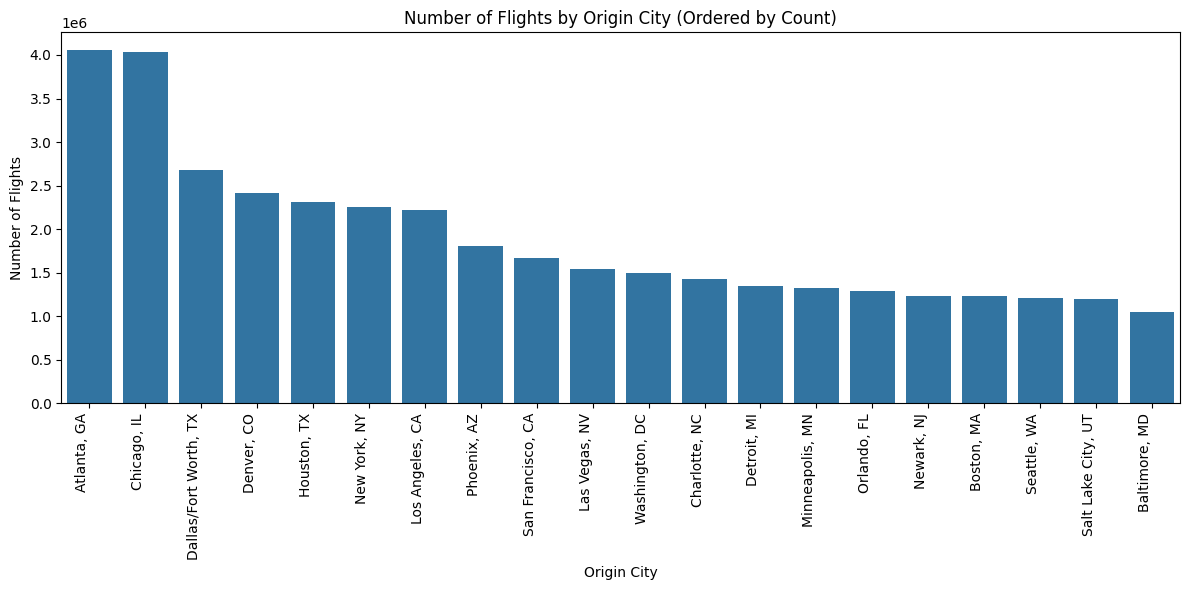

In [ ]:
origin_city_counts = df.groupBy("DEST_CITY").count().orderBy("count", ascending=False).head(20)

origin_city_counts_data = origin_city_counts
origin_cities = [row["DEST_CITY"] for row in origin_city_counts_data]
counts = [row["count"] for row in origin_city_counts_data]

plt.figure(figsize=(12, 6))
sns.barplot(x=origin_cities, y=counts)
plt.title("Number of Flights by Destination City (Ordered by Count)")
plt.xlabel("Destination City")
plt.ylabel("Number of Flights")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

Here we can see quite interesting results. Most common destionations are not the percieved the most popular (at least touristically) cities in the US. They are rather some large transportation hubs.

## Analyze delays

Lets take a look at what airlines are most delayed

In [18]:
airline_delays = (
    df.filter(col("DEP_DELAY") > 0)
    .groupBy("AIRLINE")
    .agg({"DEP_DELAY": "avg"})
    .withColumnRenamed("avg(DEP_DELAY)", "AVG_DEP_DELAY")
    .orderBy("AVG_DEP_DELAY", ascending=False)
)
airline_delays.show()


+--------------------+------------------+
|             AIRLINE|     AVG_DEP_DELAY|
+--------------------+------------------+
|       Allegiant Air| 49.50083636153891|
|    Republic Airline| 47.50400662377707|
|ExpressJet Airlin...| 45.33466329844086|
|   PSA Airlines Inc.| 44.44082290490953|
|    Spirit Air Lines| 44.00797763735639|
|  Mesa Airlines Inc.| 43.16194000751995|
|     JetBlue Airways| 41.69404030902026|
|   Endeavor Air Inc.| 40.80383277569815|
|SkyWest Airlines ...| 40.21334778935956|
|Sun Country Airlines|37.836080195107115|
|Frontier Airlines...| 36.54137343338086|
|           Envoy Air| 36.03149943890809|
|      Virgin America| 34.58588658988211|
|American Airlines...| 34.54752993937592|
|United Air Lines ...| 34.03830714824396|
|Delta Air Lines Inc.| 31.24550163644581|
|     AirTran Airways|30.102619710608117|
|         Horizon Air| 27.23861352980576|
|  Northwest Airlines| 26.56877638899075|
|Alaska Airlines Inc.|26.325695911968552|
+--------------------+------------

Now visualize this data

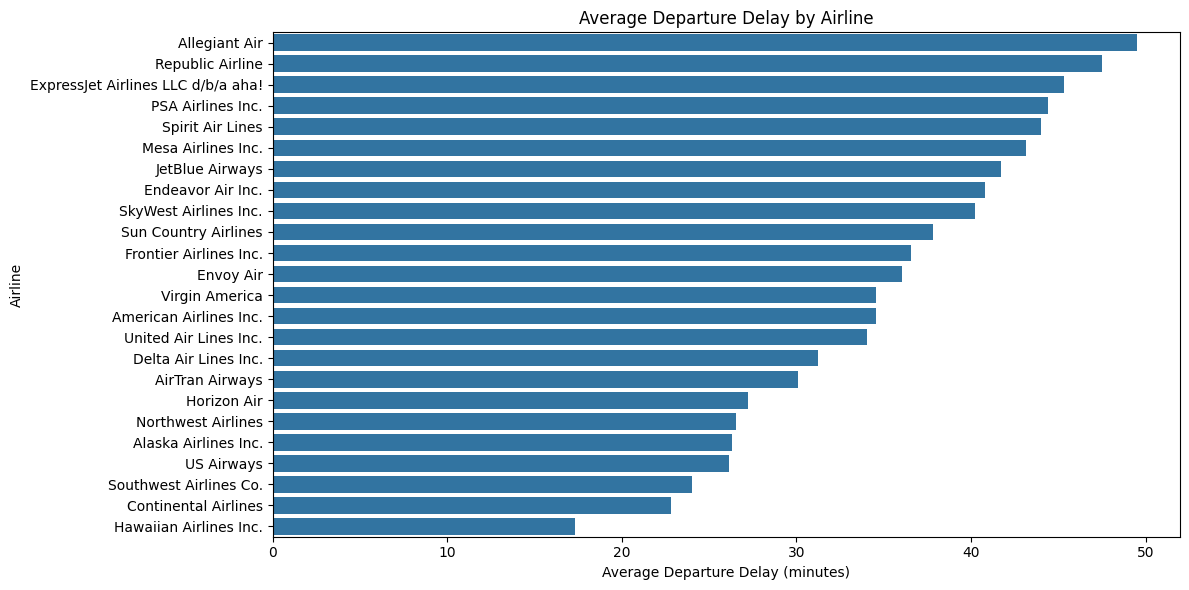

In [ ]:
airline_delays_data = airline_delays.collect()

airline_names = [row['AIRLINE'] for row in airline_delays_data]
avg_dep_delays = [row['AVG_DEP_DELAY'] for row in airline_delays_data]

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_dep_delays, y=airline_names)
plt.title("Average Departure Delay by Airline")
plt.xlabel("Average Departure Delay (minutes)")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()

This data is quite interesting and useful. It may show people which airline to choose when planning a trip, especially when time is of great importance.

We can also take a look at delays' severity for each airline

In [20]:
df = df.withColumn(
    "DELAY_SEVERITY",
    when(col("DEP_DELAY") <= 0, "No Delay")
    .when(col("DEP_DELAY") <= 20, "Minor Delay")
    .otherwise("Severe Delay")
)

delay_severity_counts = df.groupBy("DELAY_SEVERITY", "AIRLINE").count().orderBy("DELAY_SEVERITY", ascending=False)
delay_severity_counts.show()



+--------------+--------------------+-------+
|DELAY_SEVERITY|             AIRLINE|  count|
+--------------+--------------------+-------+
|  Severe Delay|    Republic Airline|  71838|
|  Severe Delay|   Endeavor Air Inc.| 174091|
|  Severe Delay|Frontier Airlines...| 177596|
|  Severe Delay|SkyWest Airlines ...| 995253|
|  Severe Delay|Southwest Airline...|2290286|
|  Severe Delay|American Airlines...|1162225|
|  Severe Delay|United Air Lines ...| 854884|
|  Severe Delay|ExpressJet Airlin...| 956638|
|  Severe Delay|Alaska Airlines Inc.| 165048|
|  Severe Delay|Delta Air Lines Inc.|1009456|
|  Severe Delay|     JetBlue Airways| 538213|
|  Severe Delay|  Mesa Airlines Inc.| 166955|
|  Severe Delay|         Horizon Air|   2451|
|  Severe Delay|           Envoy Air| 608028|
|  Severe Delay|       Allegiant Air|  29935|
|  Severe Delay|Hawaiian Airlines...|  35707|
|  Severe Delay|   PSA Airlines Inc.| 130867|
|  Severe Delay|    Spirit Air Lines| 133064|
|  Severe Delay|Sun Country Airlin

And now visualize different delay severity cases for each airline

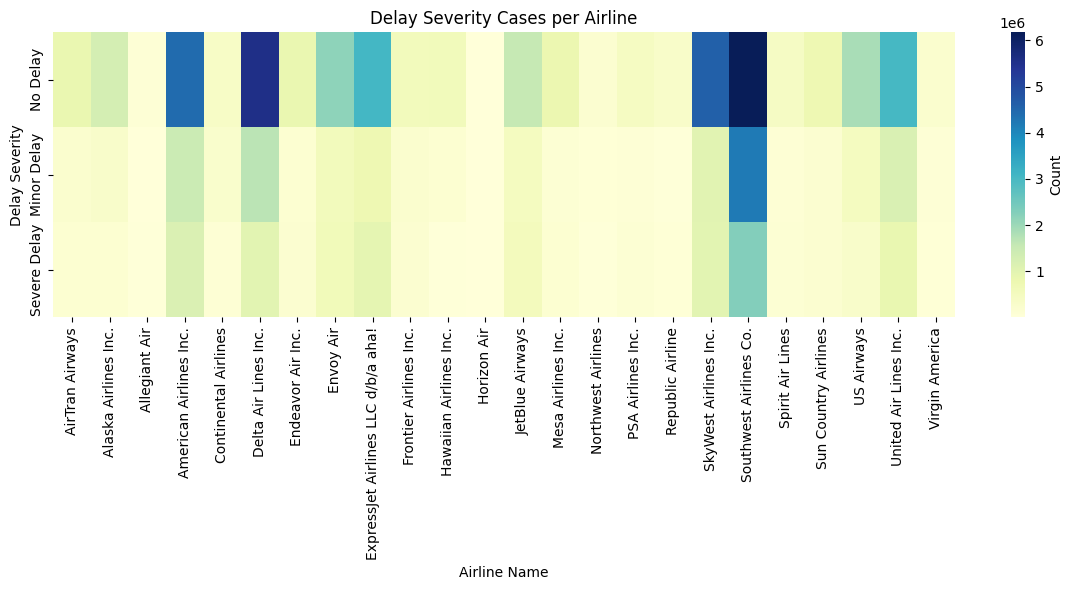

In [21]:
delay_severity_counts = df.groupBy("DELAY_SEVERITY", "AIRLINE").count()

pivot_df = delay_severity_counts.groupBy("DELAY_SEVERITY").pivot("AIRLINE").agg(F.first("count")).na.fill(0)

delay_severity_data = pivot_df.collect()

delay_severity_labels = [row['DELAY_SEVERITY'] for row in delay_severity_data]
airline_names = pivot_df.columns[1:]
counts_matrix = [[row[col] for col in pivot_df.columns[1:]] for row in delay_severity_data]

plt.figure(figsize=(12, 6))
sns.heatmap(counts_matrix, annot=False, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'}, xticklabels=airline_names, yticklabels=delay_severity_labels)
plt.title("Delay Severity Cases per Airline")
plt.xlabel("Airline Name")
plt.ylabel("Delay Severity")
plt.tight_layout()
plt.show()

And this shows number of serious delays per airline over the course of all years included in the dataset. As wee can see, Southwest Airlines and Delta Airlines have the most severe delays.

Now lets take a look at delay times distribution

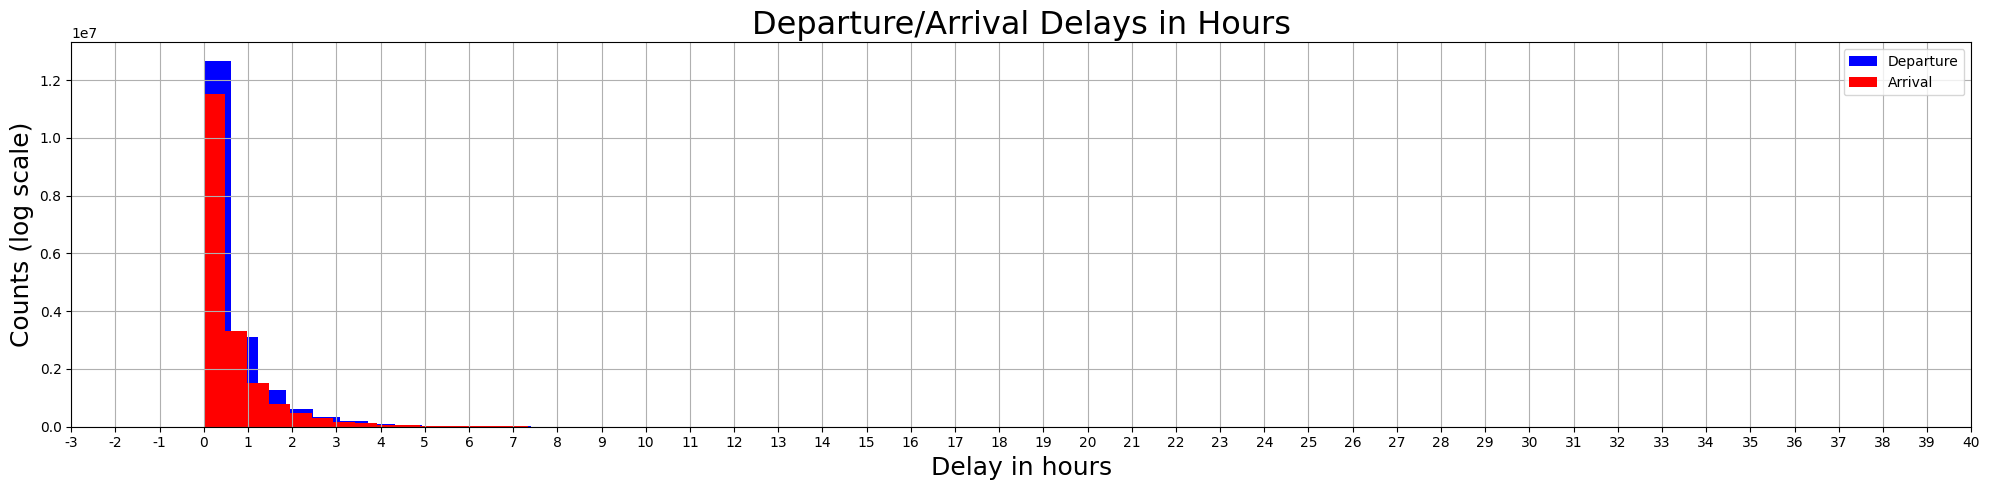

In [22]:
df_filtered = df.filter((df['DEP_DELAY'] >= 0) & (df['ARR_DELAY'] >= 0))

dep_delays = [row['DEP_DELAY'] for row in df_filtered.select('DEP_DELAY').collect()]
arr_delays = [row['ARR_DELAY'] for row in df_filtered.select('ARR_DELAY').collect()]

plt.figure(figsize=(20, 5))
plt.hist(dep_delays, bins=80, label='Departure', color='blue')
plt.hist(arr_delays, bins=100, label='Arrival', color='red')

plt.xticks(np.arange(-180, 2401, 60), labels=np.arange(-180, 2401, 60)//60)

plt.xlim(-180, 2400)

plt.xlabel('Delay in hours', fontsize=18)
plt.ylabel('Counts (log scale)', fontsize=18)
plt.title('Departure/Arrival Delays in Hours', fontsize=23)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Now let's make Y scale logarithmic to better see the data

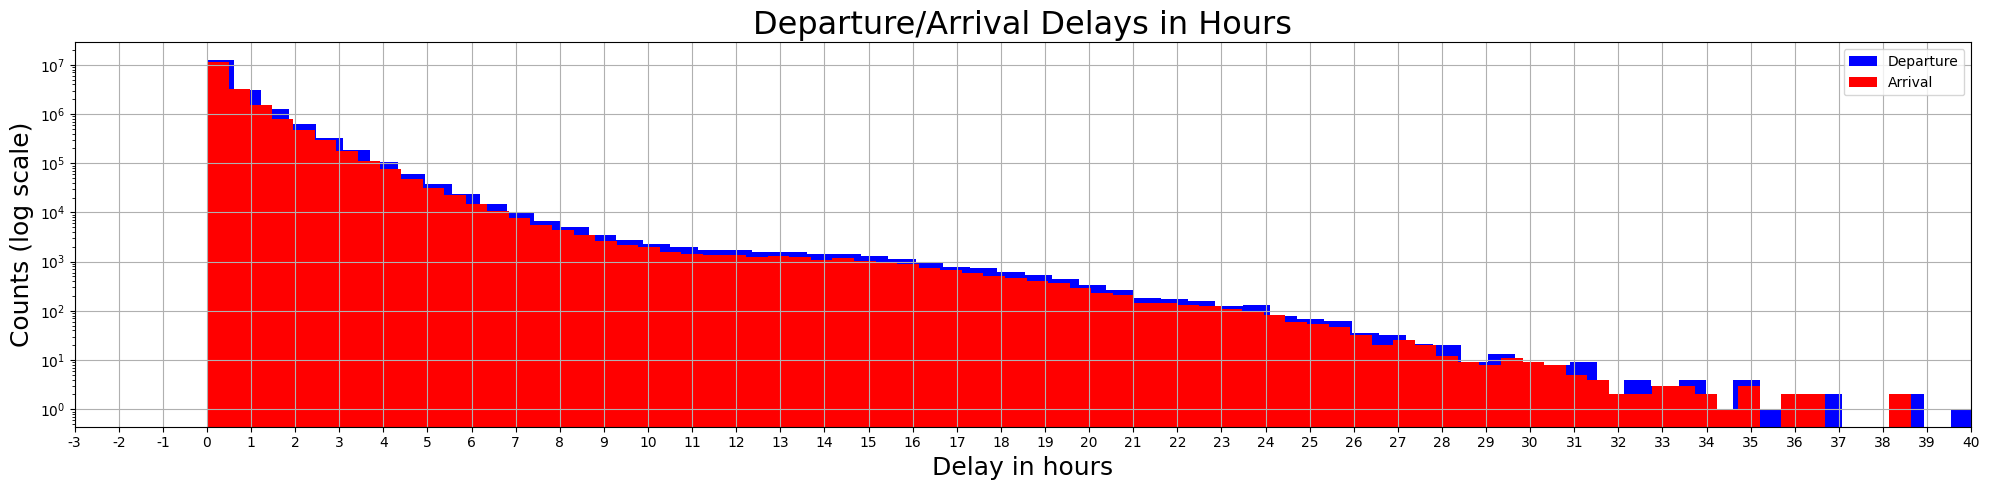

In [23]:
df_filtered = df.filter((df['DEP_DELAY'] >= 0) & (df['ARR_DELAY'] >= 0))

dep_delays = [row['DEP_DELAY'] for row in df_filtered.select('DEP_DELAY').collect()]
arr_delays = [row['ARR_DELAY'] for row in df_filtered.select('ARR_DELAY').collect()]

plt.figure(figsize=(20, 5))
plt.hist(dep_delays, bins=80, label='Departure', color='blue')
plt.hist(arr_delays, bins=100, label='Arrival', color='red')

plt.yscale("log")

plt.xticks(np.arange(-180, 2401, 60), labels=np.arange(-180, 2401, 60)//60)

plt.xlim(-180, 2400)

plt.xlabel('Delay in hours', fontsize=18)
plt.ylabel('Counts (log scale)', fontsize=18)
plt.title('Departure/Arrival Delays in Hours', fontsize=23)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Now this plot with log y axis is much more pleasant to look at and analyze. We can see that arrival and departure delays are very close. This indicates that there aren't many cases when departure delay can be eliminated by goind faster etc.

Now lets take a different angle on departure/arrival delays

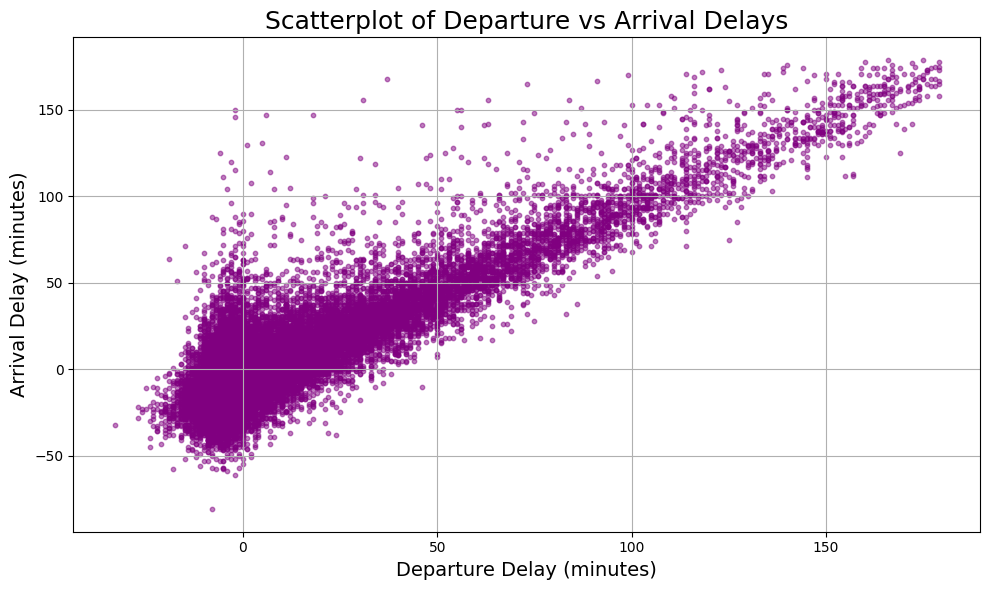

In [24]:
df_filtered = df.filter((df['DEP_DELAY'] < 180) & (df['ARR_DELAY'] < 180))

df_sampled = df_filtered.sample(withReplacement=False, fraction=50000/df_filtered.count(), seed=0)

dep_delays = [row['DEP_DELAY'] for row in df_sampled.select('DEP_DELAY').collect()]
arr_delays = [row['ARR_DELAY'] for row in df_sampled.select('ARR_DELAY').collect()]

plt.figure(figsize=(10, 6))

plt.scatter(dep_delays, arr_delays, alpha=0.5, color='purple', marker='o', s=10)

plt.title("Scatterplot of Departure vs Arrival Delays", fontsize=18)
plt.xlabel("Departure Delay (minutes)", fontsize=14)
plt.ylabel("Arrival Delay (minutes)", fontsize=14)

plt.grid(True)

plt.tight_layout()
plt.show()

This plot, on the other hand tells a bit different story. We can see that the relation between arrival and departure delays is still mostly linear. However, there are two intrersting moments. One is that on the left, there is a deviation in arrival delays, which makes the whole plot look similar to Nike logo. The second one is that above the mass center, there is a disperion, meaning there are much more outliers than under the mass center. Those both things indicate that sometimes, there are cases when with lower departure delay, arrival delay is bigger. Meaning there are delays in flight (weather, for example), or right before landing (waiting for runway clearance, for example).

## Modelling

We had OutOfMemoryError, which resulted the execution halt. Due to this, execution was continued from merging two datasets again, skipping the analysis.

In [7]:
df = df.union(df2)

df.printSchema()
df.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 

24/12/13 09:46:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+------------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|AIRLINE_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+------------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------

In order to make this a classification problem, we added a "label" column which indicates whether the flight was delayed by more than 10 minutes. 1 indicates delay greater than 10 minutes, 0 indicates delay less than 10 minutes. We also removed cancelled and diverted flights.

In [ ]:
from pyspark.sql.functions import when, col

df_filtered = df.filter((col("CANCELLED") == 0.0) & (col("DIVERTED") == 0.0))

df_model = df_filtered.withColumn("label", when(col("ARR_DELAY") > 10, 1).otherwise(0))

class_distribution = df_model.groupBy("label").count().orderBy("label")
class_distribution.show()


+-----+--------+
|label|   count|
+-----+--------+
|    0|49233117|
|    1|14118900|
+-----+--------+



COMMENT FOR THIS TABLE ABOVE

**Feature Engineering**

Extract some time-based features and encode categorical variables. We’ll assume FL_DATE is a date column and we can extract day of week. For CRS_DEP_TIME, we can convert it to an hour of day. For airline, origin, dest we can use StringIndexer and OneHotEncoder. Also include month feature

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import hour, dayofweek, month

df_model = df_model.withColumn("MONTH", month("FL_DATE"))

df_model = df_model.withColumn("CRS_DEP_HOUR", (F.col("CRS_DEP_TIME")/100).cast("int"))
df_model = df_model.withColumn("DAY_OF_WEEK", dayofweek("FL_DATE"))
df_model = df_model.na.drop(subset=["CRS_DEP_TIME"])

feature_cols = ["AIRLINE_CODE", "ORIGIN", "DEST", "DISTANCE", "CRS_DEP_HOUR", "DAY_OF_WEEK", "MONTH"]

string_indexers = [StringIndexer(inputCol=colName, outputCol=colName+"_idx", handleInvalid="keep") 
                    for colName in ["AIRLINE_CODE", "ORIGIN", "DEST"]]

encoder = OneHotEncoder(inputCols=["AIRLINE_CODE_idx", "ORIGIN_idx", "DEST_idx"], 
                        outputCols=["AIRLINE_CODE_ohe", "ORIGIN_ohe", "DEST_ohe"], handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["AIRLINE_CODE_ohe", "ORIGIN_ohe", "DEST_ohe", "DISTANCE", "CRS_DEP_HOUR", "DAY_OF_WEEK", "MONTH"],
    outputCol="features"
)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=string_indexers + [encoder, assembler])
df_prepared = pipeline.fit(df_model).transform(df_model)

df_prepared.select("label", "features").show(5, truncate=False)


+-----+-------------------------------------------------------------------+
|label|features                                                           |
+-----+-------------------------------------------------------------------+
|0    |(828,[4,50,440,824,825,826,827],[1.0,1.0,1.0,1065.0,11.0,4.0,1.0]) |
|0    |(828,[1,36,438,824,825,826,827],[1.0,1.0,1.0,1399.0,21.0,7.0,11.0])|
|0    |(828,[4,28,436,824,825,826,827],[1.0,1.0,1.0,680.0,9.0,6.0,7.0])   |
|1    |(828,[1,36,432,824,825,826,827],[1.0,1.0,1.0,1589.0,16.0,2.0,3.0]) |
|0    |(828,[17,37,427,824,825,826,827],[1.0,1.0,1.0,985.0,18.0,1.0,2.0]) |
+-----+-------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
print("FL_DATE nulls:", df_model.filter(F.col("FL_DATE").isNull()).count())
print("CRS_DEP_TIME nulls:", df_model.filter(F.col("CRS_DEP_TIME").isNull()).count())

FL_DATE nulls: 0


CRS_DEP_TIME nulls: 0


## Train a Logistic Regression model

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = df_prepared.randomSplit([0.7, 0.3], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

lr_predictions.groupBy("label", "prediction").count().show()


Logistic Regression AUC: 0.6236423894143007


+-----+----------+--------+
|label|prediction|   count|
+-----+----------+--------+
|    1|       0.0| 4230074|
|    0|       0.0|14765804|
|    1|       1.0|    4745|
|    0|       1.0|    7310|
+-----+----------+--------+



In [15]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

rf_predictions.groupBy("label", "prediction").count().show()


24/12/13 03:16:47 WARN MemoryStore: Not enough space to cache rdd_1503_13 in memory! (computed 374.6 MiB so far)
24/12/13 03:16:47 WARN BlockManager: Persisting block rdd_1503_13 to disk instead.
24/12/13 03:16:47 WARN MemoryStore: Not enough space to cache rdd_1503_11 in memory! (computed 374.6 MiB so far)
24/12/13 03:16:47 WARN BlockManager: Persisting block rdd_1503_11 to disk instead.
24/12/13 03:16:47 WARN MemoryStore: Not enough space to cache rdd_1503_15 in memory! (computed 562.0 MiB so far)
24/12/13 03:16:47 WARN BlockManager: Persisting block rdd_1503_15 to disk instead.
24/12/13 03:16:47 WARN MemoryStore: Not enough space to cache rdd_1503_12 in memory! (computed 562.0 MiB so far)
24/12/13 03:16:47 WARN BlockManager: Persisting block rdd_1503_12 to disk instead.
24/12/13 03:16:47 WARN MemoryStore: Not enough space to cache rdd_1503_14 in memory! (computed 562.0 MiB so far)
24/12/13 03:16:47 WARN BlockManager: Persisting block rdd_1503_14 to disk instead.
24/12/13 03:16:48 WA

Random Forest AUC: 0.5409915765198251


+-----+----------+--------+
|label|prediction|   count|
+-----+----------+--------+
|    1|       0.0| 4234819|
|    0|       0.0|14773114|
+-----+----------+--------+



### TODO: ML Flow can be added here (not finished yet)

In [ ]:
import mlflow
import mlflow.spark

mlflow.set_tracking_uri("file:////home/yurii/ucu/bigdata/Project/archive/experiment_logs/mlruns")


In [ ]:
import os
import mlflow
from pyspark.sql import DataFrame

os.makedirs("experiment_logs", exist_ok=True)

hyperparams = {
    "Logistic Regression": [{}],
    "Random Forest": [{"numTrees": n} for n in [10, 15, 20]],
    "GBT": [{"maxIter": i} for i in [10, 20, 50]],
}

models = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "GBT": GBTClassifier,
}

results = []

for model_name, model_class in models.items():
    for params in hyperparams[model_name]:
        with mlflow.start_run(run_name=f"{model_name} {params}"):
            model = model_class(featuresCol="features", labelCol="label", **params)
            fitted_model = model.fit(train)
            predictions = fitted_model.transform(test)

            auc = evaluator.evaluate(predictions)
            print(f"{model_name} {params} AUC: {auc}")

            param_str = "_".join(f"{k}_{v}" for k, v in params.items())
            predictions_path = f"experiment_logs/{model_name.replace(' ', '_').lower()}_{param_str}_predictions.csv"
            predictions.select("label", "prediction", "probability").write.csv(
                predictions_path, header=True, mode="overwrite"
            )

            mlflow.log_params(params)
            mlflow.log_metric("AUC", auc)
            mlflow.spark.log_model(fitted_model, f"{model_name.lower()}_model_{param_str}")
            mlflow.log_artifact(predictions_path, artifact_path="predictions")

            results.append({"model_name": model_name, "params": params, "auc": auc, "path": predictions_path})


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for model_name in results_df["model_name"].unique():
    subset = results_df[results_df["model_name"] == model_name]
    plt.plot(
        subset["params"].apply(str),
        subset["auc"],
        marker="o",
        label=model_name,
    )

plt.title("Model Performance (AUC) Across Hyperparameters")
plt.xlabel("Hyperparameters")
plt.ylabel("AUC")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

path_to_analyze = results_df.loc[0, "path"]
spark_predictions = spark.read.csv(path_to_analyze, header=True)
spark_predictions.show(5)


In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("file:////home/yurii/ucu/bigdata/Project/archive/experiment_logs/mlruns")

client = MlflowClient()

experiments = client.list_experiments()
print("Experiments:")
for exp in experiments:
    print(f"ID: {exp.experiment_id}, Name: {exp.name}")

experiment_id = experiments[0].experiment_id

runs = client.list_run_infos(experiment_id)
print("\nRuns:")
for run in runs:
    print(f"Run ID: {run.run_id}, Status: {run.status}")

run_id = runs[0].run_id
run = client.get_run(run_id)
print("\nRun Details:")
print(f"Run ID: {run.info.run_id}")
print(f"Params: {run.data.params}")
print(f"Metrics: {run.data.metrics}")
print(f"Artifacts URI: {run.info.artifact_uri}")

artifacts = client.list_artifacts(run_id)
for artifact in artifacts:
    print(f"Artifact: {artifact.path}")
    if artifact.is_dir:
        print("Directory contents:", client.list_artifacts(run_id, artifact.path))


In [ ]:
!mlflow ui --backend-store-uri file:///home/yurii/ucu/bigdata/Project/archive/experiment_logs/mlruns
